In [1]:
from ksql import KSQLAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
client = KSQLAPI('http://localhost:8088/')

In [2]:
client.ksql('show topics')

[{'@type': 'kafka_topics',
  'statementText': 'show topics;',
  'topics': [{'name': 'default_ksql_processing_log', 'replicaInfo': [1]},
   {'name': 'raw-phone-stream', 'replicaInfo': [1]}],
  'warnings': []}]

In [6]:
client.create_stream(table_name='device_stream',
                     columns_type=['name varchar',
                                   'time bigint',
                                   'values_x double',
                                   'values_y double',
                                   'values_z double',
                                   'messageId bigint',
                                   'sessionId varchar',
                                   'deviceId varchar'
                                   ],
                     topic='raw-phone-stream',
                     value_format='JSON')

True

In [3]:
def maybe_load_json(x):

    try:

        return json.loads(x)
    
    except:

        return x

In [4]:
recent_stream = client.query('''
        select deviceId,
            time,
            values_x,
            values_y,
            values_z
        from device_stream
        where name = 'accelerometeruncalibrated'
        limit 10
    ''', use_http2=True)

for row in recent_stream:

    obj = maybe_load_json(row)
    if type(obj) == list:

        print(obj)

['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398761630000, 0.03057861328125, -0.1905059814453125, -0.94598388671875]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398781687000, 0.0240325927734375, -0.2205963134765625, -0.92840576171875]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398801745000, 0.0257110595703125, -0.255401611328125, -0.9612884521484375]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398821802000, 0.0332794189453125, -0.249359130859375, -0.9795989990234375]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398841859000, 0.031280517578125, -0.230712890625, -0.9974365234375]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398861917000, 0.043609619140625, -0.2084503173828125, -1.01629638671875]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398881974000, 0.05615234375, -0.1943359375, -1.008575439453125]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681408398902032000, 0.053802490234375, -0.200103759765625, -0.9772186279296875]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 

In [11]:
obj = ['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680103085213837300, -0.017425537109375, -0.403656005859375, -0.9019927978515625]
obj[1] = str(pd.to_datetime(obj[1]))
obj

['86a5b0e3-6e06-40e2-b226-5a72bd39b65b',
 '2023-03-29 15:18:05.213837300',
 -0.017425537109375,
 -0.403656005859375,
 -0.9019927978515625]

In [18]:
from retry import retry

@retry()
def ksql_stream(query:str):

    recent_stream = client.query(query, use_http2=True)

    for row in recent_stream:
        
        return row

In [19]:
query = '''
        select deviceId,
            time,
            values_x,
            values_y,
            values_z
        from device_stream
        where name = 'accelerometeruncalibrated'
        emit changes
    '''

ksql_stream(query)

'{"queryId":"transient_DEVICE_STREAM_3039824524561922414","columnNames":["DEVICEID","TIME","VALUES_X","VALUES_Y","VALUES_Z"],"columnTypes":["STRING","BIGINT","DOUBLE","DOUBLE","DOUBLE"]}\n'

In [5]:
while True:

    try:

        recent_stream = client.query('''
            select deviceId,
                time,
                values_x,
                values_y,
                values_z
            from device_stream
            where name = 'accelerometeruncalibrated'
            emit changes
        ''', use_http2=True)

        for row in recent_stream:
            print(maybe_load_json(row))


    except:

        continue


{'queryId': 'transient_DEVICE_STREAM_8723023552929061870', 'columnNames': ['DEVICEID', 'TIME', 'VALUES_X', 'VALUES_Y', 'VALUES_Z'], 'columnTypes': ['STRING', 'BIGINT', 'DOUBLE', 'DOUBLE', 'DOUBLE']}
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311024994300, -0.176361083984375, -0.2475433349609375, -0.9630889892578125]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311045050400, -0.1563568115234375, -0.264556884765625, -0.9808349609375]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311065106400, -0.15728759765625, -0.256988525390625, -0.99407958984375]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311085161500, -0.1479644775390625, -0.248504638671875, -0.9907684326171875]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311105217500, -0.151031494140625, -0.2430877685546875, -0.98052978515625]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311125273300, -0.1499786376953125, -0.241058349609375, -0.950836181640625]
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1681650311145329400, -0.15

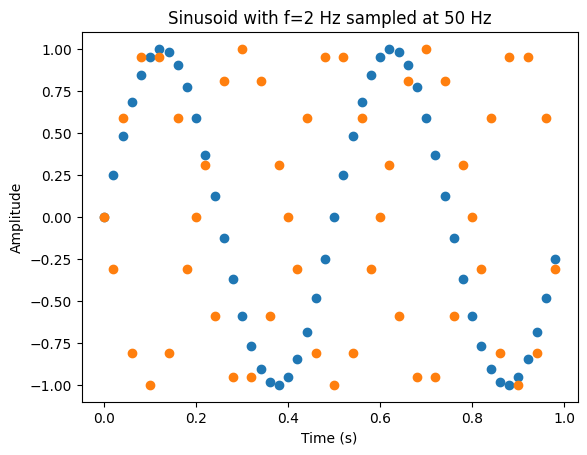

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling rate and duration
fs = 50  # sampling rate (in Hz)
T = 1   # duration (in seconds)

# Define the time vector
t = np.arange(0, T, 1/fs)

# Define the frequency and amplitude of the sinusoid
f = 2  # frequency (in Hz)
A = 1   # amplitude

# Generate the sinusoid
x = A * np.sin(2*np.pi*f*t)
x2 = A * np.sin(55*np.pi*t)

# Plot the sinusoid
plt.scatter(t, x)
plt.scatter(t, x2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sinusoid with f={} Hz sampled at {} Hz'.format(f, fs))
plt.show()